# Langevin dynamics
In this notebook we will introduce you to computational methods to sample from a target distribution using Langevin Monte Carlo (LMC) methods.

## Motivation: Score-based generative models
Given access to samples $\{x_i\}$ from a target distribution with *unknown* density $\mu_\text{data}$, generative models seek to learn the underlying distribution and generate more samples from $\mu_\text{data}$. As usual, we will sample from an easy to sample distribution and we will transform such samples that will correspond to samples of the target distribution.

### Forward SDE
Score-based generative models (SGM) do this by employing two stochastic differential equations (SDEs). The first one is called the **forward SDE**.

Recall that under a few regularite assumptions, any SDE of the form
$$\begin{array}{rcl}
        \mathrm{d}X_t & = & f(X_t,t)\mathrm{d}t + g(t)\mathrm{d}W_t \\
        X_0 & \sim & \mu_\text{data}.
\end{array}
$$
with *drift coefficient* $f$ and *diffusion coefficient* $g$ has a corresponding Fokker-Planck equation given by
$$\partial_{t}p(x,t) = \nabla_{x}\cdot(f(x,t)p(x,t)) + \frac{1}{2}g(t)^{2}\Delta_{x} p(x,t).$$

From now on let $p_{t}(x) := p(x,t)$ and we note that $p_{0} = \mu_{\text{data}}$. We suppose that we run this SDE until a terminal time $T$.
### Reverse SDE
The previous SDE has the following **reverse-time SDE**
$$\begin{array}{rcl}
        \mathrm{d}Y_t & = & [f(Y_t,t) + g(t)^2\nabla \log{p_t(Y_t)}]\mathrm{d}t + g(t)\mathrm{d}W_t\\
        Y_0 & \sim & q_0
\end{array}$$
where $Y_t = X_{T-t}$, $q_t = p_{T-t}$ so $q_0 = p_T$. If we know $p_T$ then we could run the reverse SDE and generate samples from $q_T = \mu_{\text{data}}$. Still knowing $p_{T}$ might not be as simple as it looks...

### The problems
We cannot access the marginals $p_t$ of the forward SDE, since we do not know $p_0 = \mu_\text{data}$. This leads to the following two problems.

1. We do not have access to $p_T$, the initial condition of the the reverse SDE,
2. For the same reason we do not know $p_{t}$ and therefore the drift $\nabla \log p_{T-t}$ of the reverse SDE.

We may solve the previous problems if we our forward SDE has some nice properties. For instance, if the probability densities of our forward SDE converge to $\mathcal{N}(0, I)$ at an exponential speed, i.e., $p_t \to \mathcal{N}(0, I)$, independently of $p_0$. Therefore, we can start the reverse SDE in $q_0 = \mathcal{N}(0, I) \approx p_T$. Then we could train a neural network approximation $s_\theta(x, t) \approx \nabla \log p_{t}(x)$ using score matching.

### How to draw samples

Once we trained a score-based model $s_{\theta}(x) \approx \nabla_{x}\log{p(x)}$, we can use an iterative procedure called Langevin dynamics to draw samples from it. The procedure goes as follows,

$$x_{i+1} = x_{i} + \epsilon \nabla_{x}\log{p_{t}(x_{i})} + \sqrt{2\epsilon}\xi_{i}, \quad i=0,1,...,K$$

where $\xi_{i}\sim \mathcal{N}(0,I)$. So, as $\epsilon \to 0$ and $K\to\infty$ one has that $x_{K}$ converges to a sample from $p_{0}(x)$.


## Numerical Examples

In [1]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
import typing

## Langevin Monte Carlo (LMC)

### Overdamped Langevin

An overdamped Langevin diffusion model has the following SDE

$$\mathrm{d}X_{t} = -\nabla f(X_{t})\mathrm{d}t + \sqrt{2}\mathrm{d}W_{t}$$

such that $X_{0}$ follows some known distribution. Then, we run the reverse-time SDE numerically using Euler-Maruyama with step size $h$ until time $T=Nh$ such that

$$x_{n+1} = x_{n} + h \nabla_{x}f(x_{n}) + \sqrt{2h}\xi_{n}, \quad n = 0,1,...,N$$

with $x_{0}$ drawn from the known initial distribution and $\xi_{n} \sim \mathcal{N}(0,I)$.


### Example 1

First, let's use a simple standard Normal distribution.

In [2]:
@partial(jax.jit)
def f(x: jax.Array) -> jax.Array:
    """
    Logarithm of Standard multivariate normal
    """
    return jax.scipy.stats.multivariate_normal.logpdf(x,
                                                      mean=jnp.zeros((x.shape[-1],)),
                                                      cov=jnp.eye(x.shape[-1]))

@partial(jax.jit)
def f1(x: jax.Array) -> jax.Array:
    """
    Standard multivariate normal
    """
    return jax.scipy.stats.multivariate_normal.pdf(x,
                                                   mean=jnp.zeros((x.shape[-1],)),
                                                   cov=jnp.eye(x.shape[-1]))


grad_f = jax.jit(jax.grad(f))
value_and_grad_f = jax.jit(jax.value_and_grad(f))

In [3]:
@partial(jax.jit, static_argnums=(2,3))
def lmc_kernel(key:jax.Array, x: jax.Array,
               grad_log: typing.Callable[[jax.Array], jax.Array],
               dt: float) -> tuple[jax.Array, jax.Array]:
    """
    LMC kernel computation using Euler-Maruyama

    Args:
        key: random number generator
        x: solution vector
        grad_log: drift term for the SDE (here the score)
        dt: time step
    """
    key, subkey = jax.random.split(key)
    paramGrad = grad_log(x)
    x = x + dt*paramGrad + jnp.sqrt(2*dt)*jax.random.normal(key=subkey, shape=(x.shape))
    return key, x


@partial(jax.jit, static_argnums=(1,2,3))
def lmc_sampler(key:jax.Array,
                grad_log: typing.Callable[[jax.Array], jax.Array],
                N: int, dt: float, x_0: jax.Array) -> jax.Array:
    """
    LMC sampler

    Args:
        key: random number generator
        grad_log: drift term for the SDE (here the score)
        N: number of point in time
        dt: time step
        x_0: initial point
    """
    def lmc_step(carry, x_dummy):
        key, x_old = carry
        key, x_new = lmc_kernel(key, x_old, grad_log, dt)
        return (key, x_new), x_new

    carry = (key, x_0)
    _, samples = jax.lax.scan(lmc_step, carry, None, N)
    return samples

In [4]:
# Parameters

n_dims = 2
K = 1000
dt = 0.01
N = 1000

In [5]:
X = jnp.zeros((K,N,2))
# parameters of initial distribution
sigma = 5
mu = jnp.array([-7,7])
for k in range(K):
    key = jax.random.PRNGKey(k)
    x_init = jax.random.multivariate_normal(key,mu,sigma*np.eye(n_dims))
    X = X.at[k, :, :].set(lmc_sampler(key, grad_f, N, dt, x_init))

We define some helper functions for plotting.

In [6]:
def plot_dynamics(X: jax.Array, num_trajs: int = 5, mode: str = "plot") -> None:
  """
  Ploting the trajectories.

  Args:
    X: trajectories to be plotted.
    num_trajs: number of trajectories to plot.
    mode: plotting mode between a regular plot or scatter.
  """

  assert num_trajs <= X.shape[0], ("Number of trajectories to plot is higher "
  "than the number of trajectories in the array")

  for i in range(num_trajs):
    if mode == "plot":
      plt.plot(X[i, :, 0], X[i, :, 1], label=f"Trajectory of $X_t^{i}$")
    elif mode == "scatter":
      plt.scatter(X[i, :, 0], X[i, :, 1], label=f"Trajectory of $X_t^{i}$")
  plt.ylabel("$x$")
  plt.xlabel("$y$")
  plt.legend()
  plt.show()


def plot_in_time(X: jax.Array, num_trajs: int = 2, mode: str = "plot") -> None:
  """
  Ploting the trajectories in function of time.

  Args:
      X: trajectories to be plotted.
      num_trajs: number of trajectories to plot.
      mode: plotting mode between a regular plot or scatter.
  """

  assert num_trajs <= X.shape[0], ("Number of trajectories to plot is higher "
  "than the number of trajectories in the array")

  N = X.shape[1]
  times = np.linspace(0,1,N)
  for i in range(num_trajs):
    if mode == "plot":
      plt.plot(times, X[0, :, i], label=f"$X_t^{i}$")
      plt.plot(times, X[1, :, i], label=f"$Y_t^{i}$")
    elif mode == "scatter":
      plt.scatter(times, X[0, :, 0], label=f"$X_t^{i}$")
      plt.scatter(times, X[1, :, 0], label=f"$Y_t^{i}$")
  plt.ylabel("$x$")
  plt.xlabel("$t$")
  plt.legend()
  plt.show()

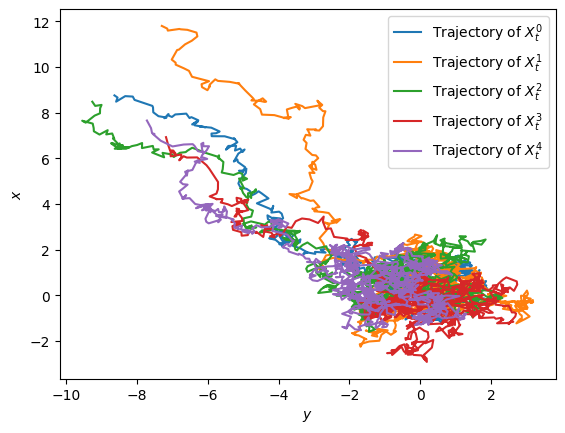

In [7]:
plot_dynamics(X)

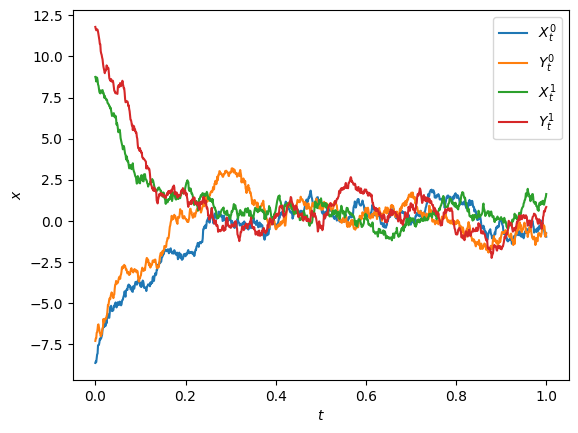

In [8]:
plot_in_time(X)

Now we compute the KL-divergenve between our estimated density and the real density function.

In [9]:
xs = np.arange(-5, 5, 0.01)
xs = np.vstack([xs,xs])
kl_div = []
for n in range(0,N,10):
    estimated_dist = scipy.stats.gaussian_kde((X[:, n, :]).T) # We estimate the distribution
    kl_div.append(scipy.stats.entropy(f1(np.transpose(xs)), estimated_dist(xs)))

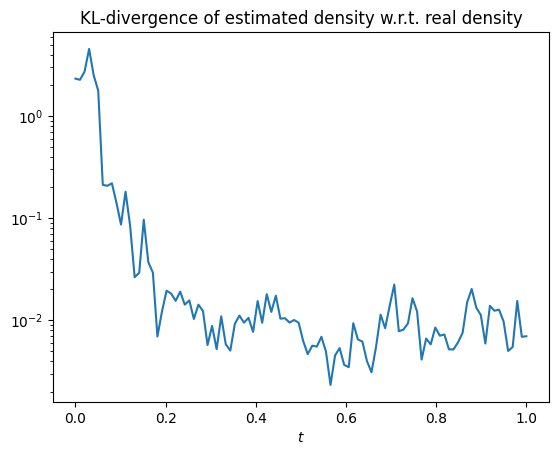

In [10]:
times = np.linspace(0,1.0,100)
plt.plot(times, kl_div)
plt.yscale("log")
plt.xlabel("$t$")
plt.title("KL-divergence of estimated density w.r.t. real density")
plt.show()

#### Metropolis Adjusted Langevin Algorithm (MALA)

In [11]:

@partial(jax.jit, static_argnums=(3,5))
def mala_kernel(key: jax.Array, x: jax.Array, grad_log_current: typing.Callable[[jax.Array],jax.Array],
                val_grad_log_post: typing.Callable[[jax.Array], tuple[jax.Array,jax.Array]],
                log_post_current: typing.Callable[[jax.Array], jax.Array], dt: float) -> tuple[jax.Array, 
                                                                                              jax.Array,
                                                                                              typing.Callable[[jax.Array],jax.Array]]:
    """"
    Kernel for the MALA step

    Args:
        key: random number generator
        grad_log_current: current drift term for the SDE (here the score)
        val_grad_log_post: value and gradient of the log function (here the score)
        log_post_current: current value of the log function
        dt: time step
    """
    key, subkey1, subkey2 = jax.random.split(key, 3)
    xProp = x + dt*grad_log_current + jnp.sqrt(2*dt)*jax.random.normal(key=subkey1,
                                                                       shape=x.shape)
    new_log_post, new_grad = val_grad_log_post(xProp)

    term1 = xProp - x - dt*grad_log_current
    term2 = x - xProp - dt*new_grad
    q_new = -0.25*(1/dt)*jnp.dot(term1, term1)
    q_current = -0.25*(1/dt)*jnp.dot(term2, term2)

    log_ratio = new_log_post - log_post_current + q_current - q_new
    acceptBool = jnp.log(jax.random.uniform(key=subkey2)) < log_ratio

    # Performing the ifs using jnp.where.
    x = jnp.where(acceptBool, xProp, x)
    current_grad = jnp.where(acceptBool, new_grad, grad_log_current)
    current_log_post = jnp.where(acceptBool, new_log_post, log_post_current)
    accepts_add = jnp.where(acceptBool, 1,0)

    return key, x, current_grad, current_log_post, accepts_add


@partial(jax.jit, static_argnums=(1,2,3))
def mala_sampler(key: jax.Array, val_grad_log_post: typing.Callable[[jax.Array], tuple[jax.Array,jax.Array]],
                 N: int, dt: float, x_0: jax.Array) -> tuple[jax.Array, jax.Array]:
    """
    MALA sampler

    Args:
        key: random number generator
        val_grad_log_post: value and gradient of the drift (here the score)
        N: number of point in time
        dt: time step
        x_0: initial point
    """
    def lmc_step(carry, x_dummy):
        key, x, current_grad, logpostCurrent, accepts = carry
        key, x, current_grad, logpostCurrent, accepts_add = mala_kernel(key,
                                                                        x,
                                                                        current_grad,
                                                                        val_grad_log_post,
                                                                        logpostCurrent,
                                                                        dt)
        accepts += accepts_add
        return (key, x, current_grad, logpostCurrent, accepts), x

    x = x_0
    logpostCurrent, current_grad = val_grad_log_post(x_0)
    carry = (key, x, current_grad, logpostCurrent, 0)
    (_, _, _, _, accepts), samples = jax.lax.scan(lmc_step, carry, None, N)
    return samples, 100*(accepts/N)


In [12]:
# Parameters

n_dims = 2
K = 500
dt = 0.01
N = 1000

In [13]:
X = jnp.zeros((K, N,n_dims))
reject_rates = jnp.zeros(K)
# parameters of initial distribution
sigma = 5
mu = jnp.array([-7,7])
for k in range(K):
    key = jax.random.PRNGKey(k)
    x_init = jax.random.multivariate_normal(key, mu, sigma*np.eye(n_dims))
    X_local, rate_local = mala_sampler(key, value_and_grad_f, N, dt, x_init)
    X = X.at[k,:,:].set(X_local)
    reject_rate = reject_rates.at[k].set(rate_local)

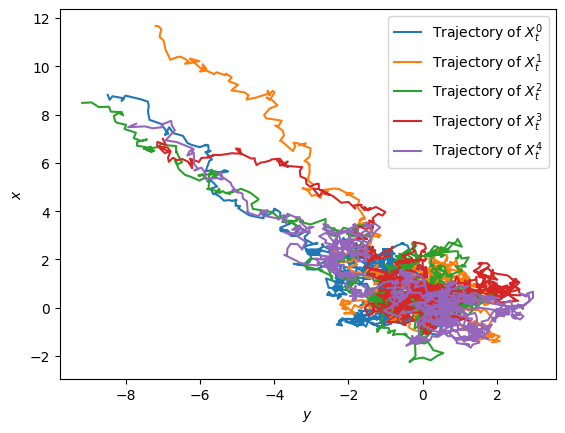

In [14]:
plot_dynamics(X)

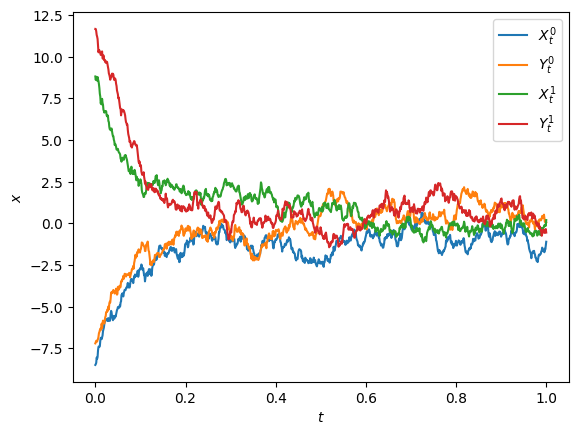

In [15]:
plot_in_time(X)

We compute the KL-divergence between the estimated density and the real density function.

In [16]:
xs = np.arange(-5,5,0.01)
xs = np.vstack([xs,xs])
kl_div = []
for n in range(0,N,10):
    estimated_dist = scipy.stats.gaussian_kde(X[:, n, :].T) # We estimate the distribution
    kl_div.append(scipy.stats.entropy(f1(np.transpose(xs)), estimated_dist(xs)))

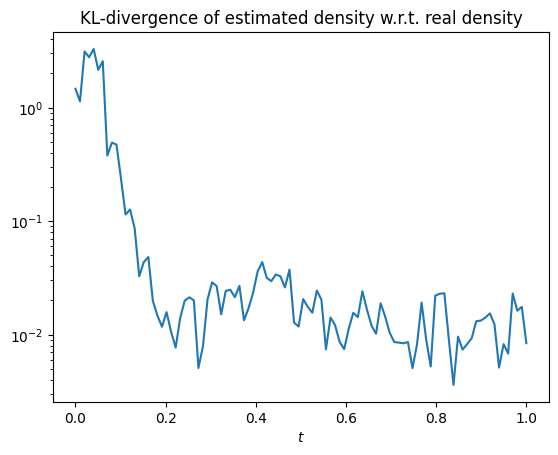

In [17]:
times = np.linspace(0,1.0,100)
plt.plot(times, kl_div)
plt.yscale("log")
plt.xlabel("$t$")
plt.title("KL-divergence of estimated density w.r.t. real density")
plt.show()

Let's check the rejection rates.

In [18]:
print(reject_rates[-10:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


We plot the field induced by the drift $\nabla f$.

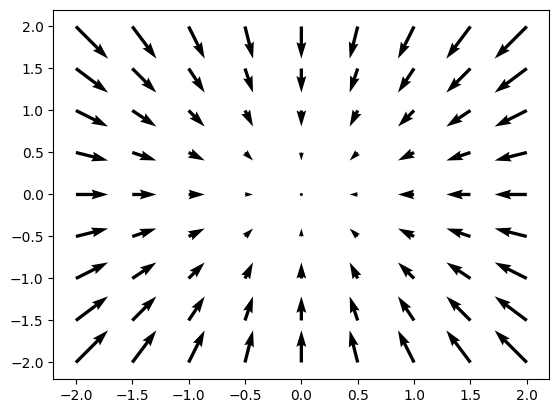

In [19]:
x, y = np.mgrid[-2:2.5:.5, -2:2.5:.5]
data = np.dstack((x, y))
plt.quiver(data[:,:,0],data[:,:,1],jax.vmap(grad_f)(data[:,:,0]),jax.vmap(grad_f)(data[:,:,1]))
plt.show()

### Example 2

We now will play with a Gaussian mixture.

In [20]:
def g(x: jax.Array) -> jax.Array:
    """
    Multi-variate normal
    """
    return jax.scipy.stats.multivariate_normal.pdf(x,
                                                   mean=jnp.ones((x.shape[-1],)),
                                                   cov=(1/5)*jnp.eye(x.shape[-1]))

def h(x: jax.Array) -> jax.Array:
    """
    Multi-variate normal
    """
    return jax.scipy.stats.multivariate_normal.pdf(x,
                                                   mean=-jnp.ones((x.shape[-1],)),
                                                   cov=(1/5)*jnp.eye(x.shape[-1]))

def gh(x: jax.Array) -> jax.Array:
    """
    Logartihm of Gaussian mixture
    """
    return jnp.log(0.5*h(x) + 0.5*g(x))


def gh1(x: jax.Array) -> jax.Array:
    """
    Gaussian mixture withe equal weights
    """
    return 0.5*h(x) + 0.5*g(x)


grad_gh = jax.jit(jax.grad(gh))
value_and_grad_gh = jax.jit(jax.value_and_grad(gh))

In [21]:
X = jnp.zeros((K, N, 2))
# parameters for the initial distribution
sigma = 1
mu = jnp.array([-1,1])
for k in range(K):
    key = jax.random.PRNGKey(k)
    x_init = jax.random.multivariate_normal(key,mu,sigma*np.eye(n_dims))
    X = X.at[k,:,:].set(lmc_sampler(key, grad_gh, N, dt, x_init))

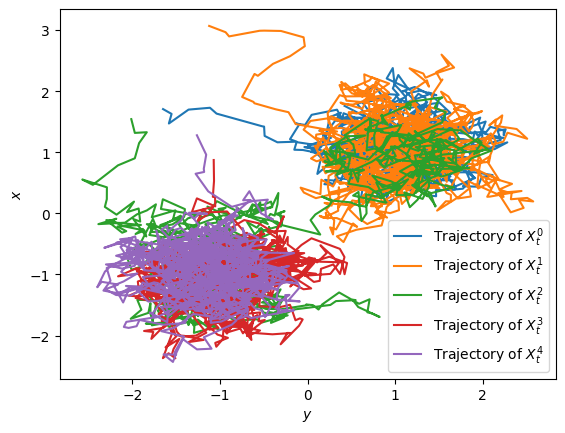

In [22]:
plot_dynamics(X)

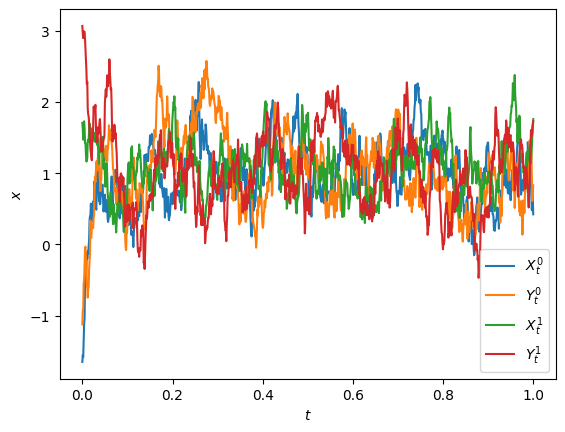

In [23]:
plot_in_time(X)

Let's check its convergence.

In [24]:
xs = np.arange(-5,5,0.01)
xs = np.vstack([xs,xs])
kl_div = []
for n in range(0,N,10):
    estimated_dist = scipy.stats.gaussian_kde(X[:,n,:].T) # We estimate the distribution
    kl_div.append(scipy.stats.entropy(f1(np.transpose(xs)), estimated_dist(xs)))

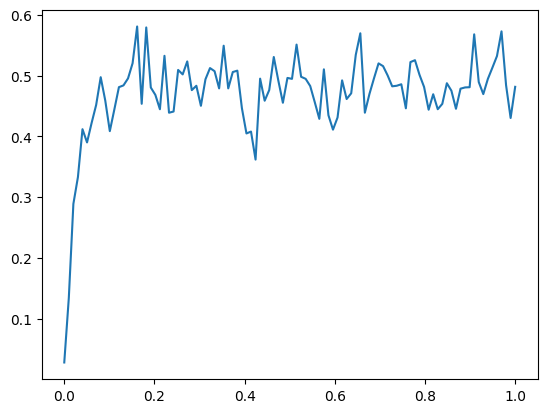

In [25]:
Time = np.linspace(0,1.0,100)
plt.plot(Time, kl_div)
plt.show()

#### Using MALA

In [26]:
# Parameters

n_dims = 2
K = 500
dt = 0.01
N = 1000
Times = np.linspace(0,1,N)

In [27]:
X = jnp.zeros((K,N,n_dims))
reject_rates = jnp.zeros(K)
# parameters of initial distribution
sigma = 1
mu = jnp.array([-1,1])
for k in range(K):
    key = jax.random.PRNGKey(k)
    x_init = jax.random.multivariate_normal(key, mu, sigma*np.eye(n_dims))
    X_local, rate_local = mala_sampler(key, value_and_grad_gh, N, dt, x_init)
    X = X.at[k,:,:].set(X_local)
    reject_rate = reject_rates.at[k].set(rate_local)

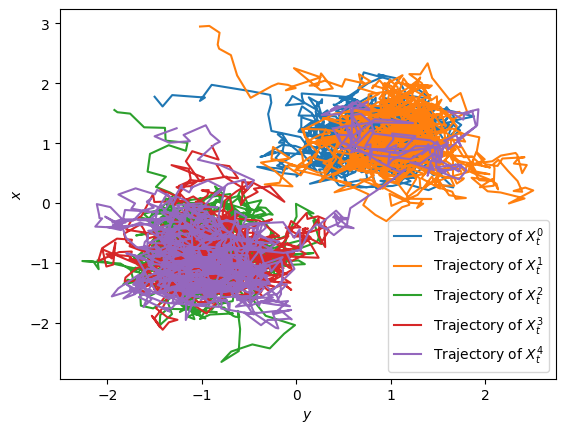

In [28]:
plot_dynamics(X)

Let's check the convergence.

In [29]:
xs = np.arange(-5,5,0.01)
xs = np.vstack([xs,xs])
kl_div = []
for n in range(0,N,10):
    estimated_dist = scipy.stats.gaussian_kde(X[:,n,:].T) # We estimate the distribution
    kl_div.append(scipy.stats.entropy(f1(np.transpose(xs)), estimated_dist(xs)))

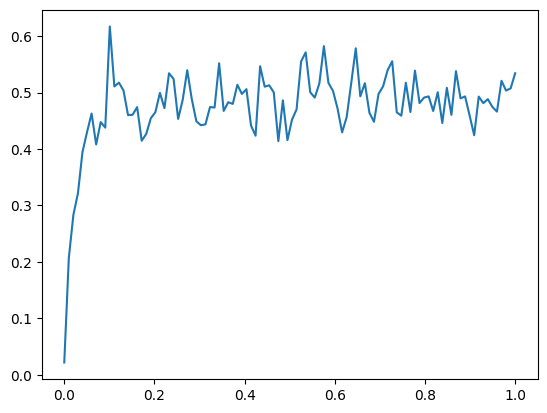

In [30]:
Time = np.linspace(0,1.0,100)
plt.plot(Time, kl_div)
#plt.yscale("log")
plt.show()

Let's see the rejection rate.

In [31]:
print(reject_rates[K-10:])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Finally, we plot the drift of the score function.

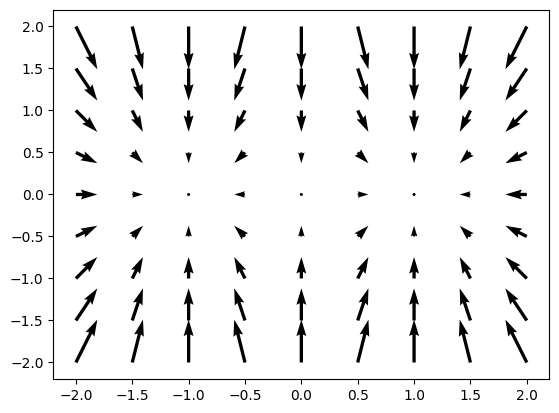

In [32]:
x, y = np.mgrid[-2:2.5:.5, -2:2.5:.5]
data = np.dstack((x, y))
plt.quiver(data[:,:,0],data[:,:,1], jax.vmap(grad_gh)(data[:,:,0]), jax.vmap(grad_gh)(data[:,:,1]))
plt.show()

## Excercises

### Excercise 1

Test the previous pipeline with a $U(-5,5)$ as the initial distribution.

## Excercise 2

Use the LMC and MALA algorithms to converge to the following distribution.

In [33]:
def j1(x:jax.Array) -> jax.Array:
    """
    Multi-variate normal
    """
    return jax.scipy.stats.multivariate_normal.pdf(x,
                                                   mean=jnp.ones((x.shape[-1],)),
                                                   cov=(1/4)*jnp.eye(x.shape[-1]))

def j2(x: jax.Array) -> jax.Array:
    """
    Multi-variate normal
    """
    return jax.scipy.stats.multivariate_normal.pdf(x,
                                                   mean=-jnp.ones((x.shape[-1],)),
                                                   cov=(1/4)*jnp.eye(x.shape[-1]))


def j3(x: jax.Array) -> jax.Array:
    """
    Multi-variate normal
    """
    return jax.scipy.stats.multivariate_normal.pdf(x,
                                                   mean=jnp.array([-10,10]),
                                                   cov=(1/20)*jnp.eye(x.shape[-1]))


def j4(x: jax.Array) -> jax.Array:
    """
    Logartihm of Gaussian mixture
    """
    return jnp.log((1/3)*j1(x) + (1/3)*j2(x) + (1/3)*j3(x))


def j41(x: jax.Array) -> jax.Array:
    """
    Gaussian mixture
    """
    return (1/3)*j1(x) + (1/3)*j2(x) + (1/3)*j3(x)

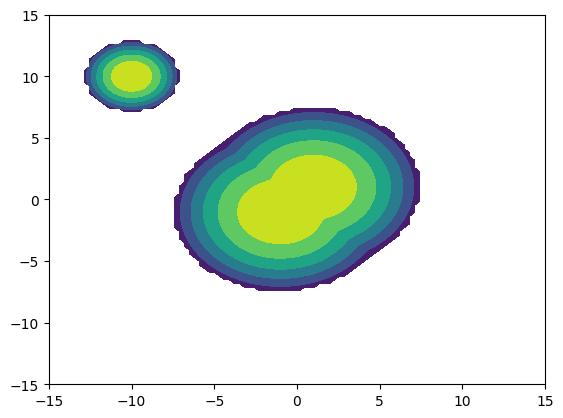

In [34]:
N = 100
x = np.linspace(-15.0, 15, N)
y = np.linspace(-15, 15, N)
X, Y = np.meshgrid(x, y)
X_input = np.concatenate((X.reshape((-1, 1)), Y.reshape((-1, 1))), axis = -1)
Z = j4(X_input)
plt.contourf(X,Y, Z.reshape((N,N)))
plt.show()